In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torchmetrics.image.inception import InceptionScore



# Устройство (GPU при наличии)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [47]:

# Параметры
batch_size = 128
z_dim = 100     # размер вектора шума
num_epochs = 5  # для демо достаточно нескольких эпох

# Загрузка набора данных CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Нормализация в диапазон [-1, 1]
])

train_dataset = datasets.CIFAR10(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform
)


dataloader_train = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)



Files already downloaded and verified
Files already downloaded and verified


## GAN

In [49]:

class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=3, img_size=32):
        super().__init__()
        self.img_size = img_size
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, img_channels * img_size * img_size),
            nn.Tanh(),  # выход в диапазоне [-1, 1]
        )

    def forward(self, x):
        return self.gen(x).view(-1, 3, self.img_size, self.img_size)


class Discriminator(nn.Module):
    def __init__(self, img_channels=3, img_size=32):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(img_channels * img_size * img_size, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid(),  # выход 0..1 (вероятность подлинности)
        )

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        return self.disc(x)


# Создаём экземпляры сети
gen = Generator(z_dim).to(device)
disc = Discriminator().to(device)

# Функция потерь и оптимизаторы
criterion = nn.BCELoss()  # бинарная кроссэнтропия
lr = 0.0002
opt_gen = optim.Adam(gen.parameters(), lr=lr)
opt_disc = optim.Adam(disc.parameters(), lr=lr)

print('done!')


done!


## Обучение GAN

In [50]:
# Обучение
for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(dataloader_train):  # Исправлено: dataloader_train
        real = real.to(device)
        batch_size_curr = real.shape[0]

        # ============ Тренируем дискриминатор ============
        # Шум -> фейковые картинки
        noise = torch.randn(batch_size_curr, z_dim).to(device)
        fake = gen(noise)

        # Вычисляем вероятность для реальных и фейковых
        disc_real = disc(real).view(-1)
        disc_fake = disc(fake.detach()).view(-1)

        # Метки (1 - настоящие, 0 - фейк)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2

        disc.zero_grad()
        lossD.backward()
        opt_disc.step()

        # ============ Тренируем генератор ============
        # Новые фейковые картинки, оцениваем дискриминатором
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))  # хотим, чтобы дискрим. сказал 1

        gen.zero_grad()
        lossG.backward()
        opt_gen.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss D: {lossD.item():.4f}, Loss G: {lossG.item():.4f}")

Epoch [1/50] | Loss D: 1.3808, Loss G: 7.2426
Epoch [2/50] | Loss D: 0.0594, Loss G: 4.8343
Epoch [3/50] | Loss D: 0.0233, Loss G: 5.8939
Epoch [4/50] | Loss D: 0.2247, Loss G: 4.7911
Epoch [5/50] | Loss D: 0.2386, Loss G: 4.0108
Epoch [6/50] | Loss D: 0.1697, Loss G: 5.0270
Epoch [7/50] | Loss D: 0.1013, Loss G: 4.1931
Epoch [8/50] | Loss D: 0.2227, Loss G: 2.7439
Epoch [9/50] | Loss D: 0.1874, Loss G: 3.0253
Epoch [10/50] | Loss D: 0.3878, Loss G: 3.2576
Epoch [11/50] | Loss D: 0.3706, Loss G: 2.7006
Epoch [12/50] | Loss D: 0.3141, Loss G: 3.0999
Epoch [13/50] | Loss D: 0.3999, Loss G: 2.5892
Epoch [14/50] | Loss D: 0.3093, Loss G: 2.6764
Epoch [15/50] | Loss D: 0.2846, Loss G: 2.5587
Epoch [16/50] | Loss D: 0.1914, Loss G: 3.0735
Epoch [17/50] | Loss D: 0.2652, Loss G: 2.6841
Epoch [18/50] | Loss D: 0.5277, Loss G: 1.5548
Epoch [19/50] | Loss D: 0.5250, Loss G: 1.4828
Epoch [20/50] | Loss D: 0.3916, Loss G: 2.4317
Epoch [21/50] | Loss D: 0.3767, Loss G: 2.1217
Epoch [22/50] | Loss D

## Вывод генерации изображений GAN

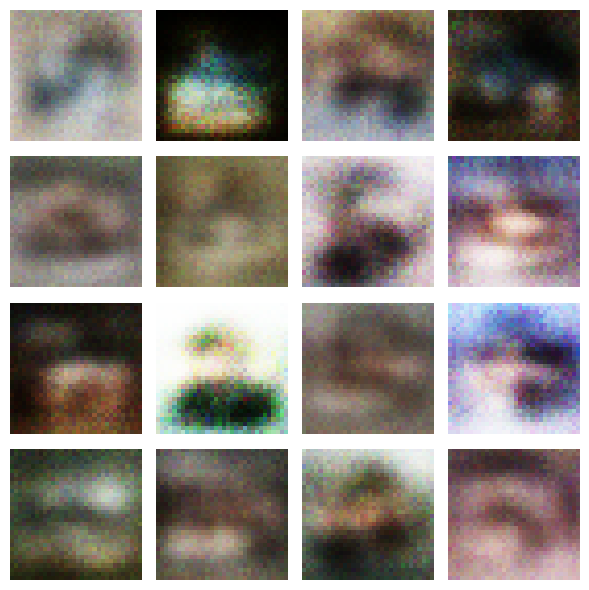

In [51]:

# Проверка генерации: берём шум и смотрим, что получится
gen.eval()
with torch.no_grad():
    sample_noise = torch.randn(16, z_dim).to(device)
    generated = gen(sample_noise).cpu()
    generated = (generated + 1) / 2  # денормализация из [-1,1] в [0,1]

# Отобразим 16 сгенерированных изображений
fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(generated[i].permute(1, 2, 0))  # Перестановка осей для отображения
    ax.axis('off')
plt.tight_layout()
plt.show()

# Метрики GAN

In [52]:
# Оценка дискриминатора
disc.eval()
total_samples = 0
correct_real = 0
correct_fake = 0

with torch.no_grad():
    for real, _ in dataloader_test:
        real = real.to(device)
        batch_size_curr = real.shape[0]

        # Реальные изображения
        real_preds = disc(real).view(-1)
        correct_real += (real_preds > 0.5).sum().item()

        # Фейковые изображения
        noise = torch.randn(batch_size_curr, z_dim).to(device)
        fake = gen(noise)
        fake_preds = disc(fake).view(-1)
        correct_fake += (fake_preds < 0.5).sum().item()

        total_samples += batch_size_curr

# Точность дискриминатора
accuracy_real = correct_real / total_samples
accuracy_fake = correct_fake / total_samples
print(f"Accuracy on real images: {accuracy_real:.4f}")
print(f"Accuracy on fake images: {accuracy_fake:.4f}")

Accuracy on real images: 0.7087
Accuracy on fake images: 0.8172


In [55]:
from IPython.display import clear_output

!pip install -q --upgrade diffusers transformers accelerate
!pip install -q torchmetrics[image]
!pip install -q lightning tbparse
!pip install torch-fidelity

print('done!')
clear_output()

In [56]:

# Инициализация метрики
inception_score = InceptionScore().to(device)

# Вычисление Inception Score
gen.eval()
with torch.no_grad():
    for _ in range(10):  # Используем несколько батчей для стабильности
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise)
        fake = (fake + 1) / 2  # денормализация из [-1,1] в [0,1]
        inception_score.update(fake)

is_mean, is_std = inception_score.compute()
print(f"Inception Score: Mean = {is_mean:.4f}, Std = {is_std:.4f}")

ModuleNotFoundError: InceptionScore metric requires that `Torch-fidelity` is installed. Either install as `pip install torchmetrics[image]` or `pip install torch-fidelity`.

In [ ]:
!git clone -q https://github.com/csinva/gan-vae-pretrained-pytorch.git
clear_output()

In [71]:
# денормализация данных 
import torchvision.transforms as transforms

class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=3, img_size=32):
        super().__init__()
        self.img_size = img_size
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, img_channels * img_size * img_size),
            nn.Tanh(),  # выход в диапазоне [-1, 1]
        )

    def forward(self, x):
        return self.gen(x).view(-1, 3, self.img_size, self.img_size)
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 16
nz = 100

# Создаём экземпляры сети
gen = Generator().to(device)
disc = Discriminator().to(device)

# Денормализация
denormalization = transforms.Compose(
    [
        transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1 / 0.5, 1 / 0.5, 1 / 0.5]),
        transforms.Normalize(mean=[-0.5, -0.5, -0.5], std=[1.0, 1.0, 1.0]),
    ]
)

noise = torch.randn(batch_size, nz, 1, 1)
imgs = denormalization(gen(noise))
imgs = (imgs * 255).type(torch.uint8)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [59]:
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)
test_dataset = datasets.CIFAR10(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform
)
print('done!')

Files already downloaded and verified


In [60]:
import lightning as L

from torchmetrics import MetricCollection
from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.fid import FrechetInceptionDistance


class RunMetric(L.LightningModule):
    def __init__(self, generator, noise_gen, detransform):
        super().__init__()
        # model
        self.generator = generator
        self.noise_gen = noise_gen
        self.detransform = detransform

        # metrics
        self.is_real = InceptionScore()
        self.is_fake = InceptionScore()

        self.fid = MetricCollection(
            {
                "FIR_64": FrechetInceptionDistance(feature=64),
                "FIR_192": FrechetInceptionDistance(feature=192),
                "FIR_768": FrechetInceptionDistance(feature=768),
                "FIR_2048": FrechetInceptionDistance(feature=2048),
            }
        )

    def test_step(self, batch, batch_idx):
        real, _ = batch
        batch_size = real.shape[0]
        noise = self.noise_gen(batch_size).to(self.device)
        fake = self.generator(noise)
        fake = self.detransform(fake)

        real = (real * 255).type(torch.uint8)
        fake = (fake * 255).type(torch.uint8)

        self.fake = fake

        self.is_real.update(real)
        self.is_fake.update(fake)

        self.fid.update(real, real=True)
        self.fid.update(fake, real=False)

    def on_test_epoch_end(self):
        is_real = self.is_real.compute()[0]
        self.log("IS_real", is_real.item())
        self.is_real.reset()

        is_fake = self.is_fake.compute()[0]
        self.log("IS_fake", is_fake.item())
        self.is_fake.reset()

        fid = self.fid.compute()
        self.log_dict(fid)
        self.fid.reset()

        fig, ax = plt.subplots(figsize=(16 * 3, 2 * 3))
        ax.imshow(
            torchvision.utils.make_grid(self.fake).permute(1, 2, 0).cpu().numpy(),
            interpolation="nearest",
            aspect="equal",
        )
        ax.axis("off")
        plt.show()

In [ ]:
def noise_gen(batch_size, nz=100):
    return torch.randn(batch_size, nz, 1, 1)

In [ ]:
!mkdir /content/lightning_logs

In [ ]:
L.seed_everything(42)

pl_model = RunMetric(generator, noise_gen, denormalization)
clear_output()
trainer = L.Trainer(max_epochs=0)
metrics = trainer.test(model=pl_model, dataloaders=test_loader)

# DCGAN

In [89]:
!pip install torch-fidelity
clear_output()

Using device: cuda
Files already downloaded and verified
Epoch [1/50] | Loss D: 0.3917, Loss G: 2.4835
Epoch [2/50] | Loss D: 0.3633, Loss G: 2.1973
Epoch [3/50] | Loss D: 0.2298, Loss G: 2.7024
Epoch [4/50] | Loss D: 0.4301, Loss G: 5.1925
Epoch [5/50] | Loss D: 0.1971, Loss G: 1.8369
Epoch [6/50] | Loss D: 0.2694, Loss G: 3.7126
Epoch [7/50] | Loss D: 0.1031, Loss G: 3.5665
Epoch [8/50] | Loss D: 0.1326, Loss G: 2.0466
Epoch [9/50] | Loss D: 0.1509, Loss G: 3.4423
Epoch [10/50] | Loss D: 0.0431, Loss G: 3.8310
Epoch [11/50] | Loss D: 0.0392, Loss G: 4.0563
Epoch [12/50] | Loss D: 0.1277, Loss G: 2.4664
Epoch [13/50] | Loss D: 0.4339, Loss G: 7.4232
Epoch [14/50] | Loss D: 0.0566, Loss G: 3.6462
Epoch [15/50] | Loss D: 0.1385, Loss G: 4.7610
Epoch [16/50] | Loss D: 0.0957, Loss G: 3.0156
Epoch [17/50] | Loss D: 0.0547, Loss G: 3.8564
Epoch [18/50] | Loss D: 0.2021, Loss G: 3.1039
Epoch [19/50] | Loss D: 0.0767, Loss G: 3.4149
Epoch [20/50] | Loss D: 0.3316, Loss G: 3.2765
Epoch [21/50

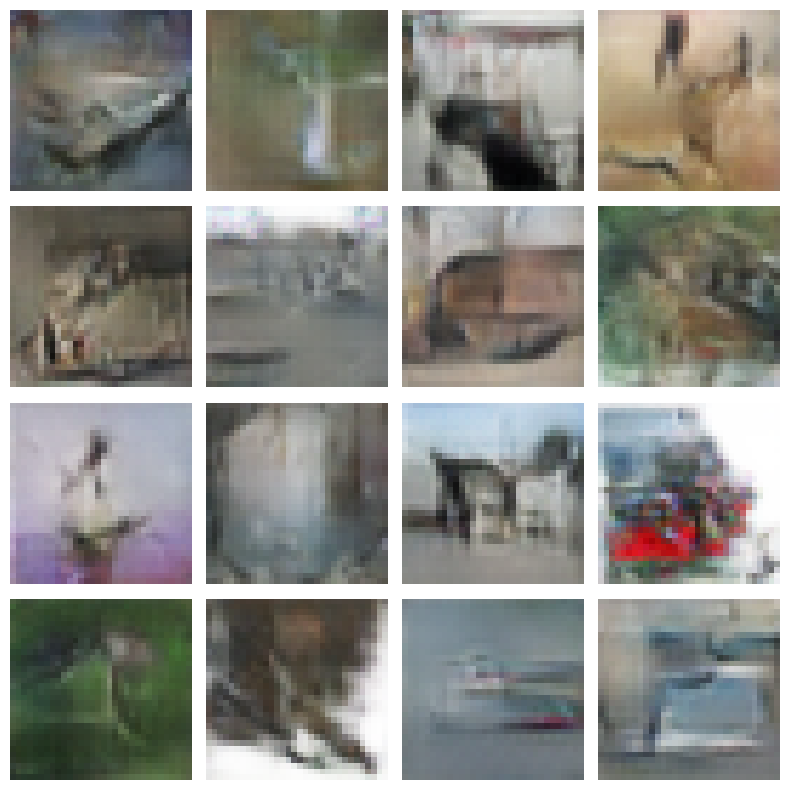

In [91]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torchmetrics.image.inception import InceptionScore

# Устройство (GPU при наличии)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Параметры
batch_size = 128
z_dim = 100  # Размерность вектора шума
num_epochs = 50  # Количество эпох
nc = 3  # Количество каналов в изображении (RGB)
ndf = 64  # Количество фильтров в дискриминаторе
ngf = 64  # Количество фильтров в генераторе
lr = 0.0002  # Скорость обучения
beta1 = 0.5  # Параметр для оптимизатора Adam

# Загрузка набора данных CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Нормализация в диапазон [-1, 1]
])

train_dataset = datasets.CIFAR10(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform
)

dataloader_train = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

# Определение дискриминатора
class Discriminator_DCGAN(nn.Module):
    def __init__(self, ngpu=1):
        super(Discriminator_DCGAN, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 32 x 32``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 16 x 16``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 8 x 8``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 4 x 4``
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# Определение генератора
class Generator_DCGAN(nn.Module):
    def __init__(self, ngpu=1):
        super(Generator_DCGAN, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(z_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d(ngf * 2, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 32 x 32``
        )

    def forward(self, input):
        return self.main(input)

# Создание моделей
gen = Generator_DCGAN().to(device)
disc = Discriminator_DCGAN().to(device)

# Функция потерь и оптимизаторы
criterion = nn.BCELoss()
opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(beta1, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=lr, betas=(beta1, 0.999))

# # Инициализация InceptionScore
# inception_score = InceptionScore().to(device)

# Обучение
for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(dataloader_train):
        real = real.to(device)
        batch_size_curr = real.shape[0]

        # ============ Тренируем дискриминатор ============
        # Шум -> фейковые картинки
        noise = torch.randn(batch_size_curr, z_dim, 1, 1).to(device)
        fake = gen(noise)

        # Вычисляем вероятность для реальных и фейковых
        disc_real = disc(real).view(-1)
        disc_fake = disc(fake.detach()).view(-1)

        # Метки (1 - настоящие, 0 - фейк)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2

        disc.zero_grad()
        lossD.backward()
        opt_disc.step()

        # ============ Тренируем генератор ============
        # Новые фейковые картинки, оцениваем дискриминатором
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))  # хотим, чтобы дискрим. сказал 1

        gen.zero_grad()
        lossG.backward()
        opt_gen.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss D: {lossD.item():.4f}, Loss G: {lossG.item():.4f}")

    # Визуализация сгенерированных изображений
    if (epoch + 1) % 50 == 0:
        with torch.no_grad():
            fake_images = gen(torch.randn(16, z_dim, 1, 1).to(device)).cpu()
            fake_images = (fake_images + 1) / 2  # Денормализация
            fake_images = fake_images.permute(0, 2, 3, 1)

            fig, axes = plt.subplots(4, 4, figsize=(8, 8))
            for i, ax in enumerate(axes.flatten()):
                ax.imshow(fake_images[i])
                ax.axis('off')
            plt.tight_layout()
            plt.show()

    # # Оценка качества сгенерированных изображений с помощью InceptionScore
    # if (epoch + 1) % 5 == 0:
    #     with torch.no_grad():
    #         fake_images = gen(torch.randn(64, z_dim, 1, 1).to(device))
    #         fake_images = (fake_images + 1) / 2  # Денормализация
    #         inception_score.update(fake_images)
    #         print(f"Inception Score: {inception_score.compute()}")

IndexError: Dimension specified as 0 but tensor has no dimensions

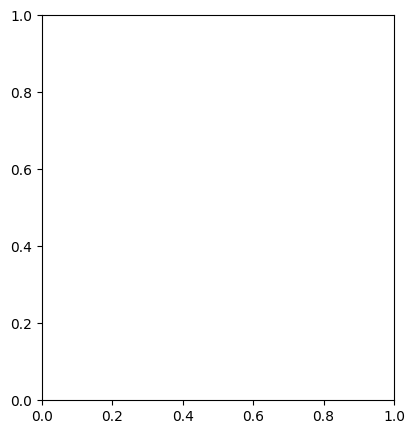

In [92]:
# Вывод графиков потерь
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(lossD[-100:], label='Discriminator Loss')
plt.plot(lossG[-100:], label='Generator Loss')
plt.title('Generator Discriminator Loss')
plt.legend()
plt.tight_layout()
plt.show()